In [66]:
from pathlib import Path
import re

root = Path(r"F:\ERA5_pressure_level\traj_clusters")

mean_files = sorted([
    f for f in root.rglob("1979_2020_03_P*/C*_mean*")  # 精确到月份+P*
    if re.fullmatch(r"C\d+_\d+_mean(?:\.tdump)?", f.name)
])

print("发现平均轨迹文件：", len(mean_files))


发现平均轨迹文件： 43


In [67]:
import pandas as pd
import numpy as np

def parse_tdump(path):
    df = pd.read_csv(
        path,
        skiprows=5,                             # 跳过头 6 行
        sep=r"\s+" ,     # 对应 13 列宽度
        names=['traj_num','sb','year','mon','day','hrs',
               'min','eight','count','lat','lon','p','zero']
    )
    return df[['lat', 'lon']].to_numpy(dtype=float)   # shape → (T,2)

In [68]:
tracks = [parse_tdump(f) for f in mean_files]
print(f"成功读取 {len(tracks)} 条平均轨迹")  

成功读取 43 条平均轨迹


In [69]:
lengths = {len(t) for t in tracks}
if len(lengths) != 1:
    raise ValueError(f"轨迹长度不一致：{sorted(lengths)}，请检查数据！")
T = lengths.pop()
print(f"统一长度：{T} 个时间步")

统一长度：241 个时间步


In [70]:
import numpy as np, itertools
from haversine import haversine_vector, Unit
from scipy.cluster.hierarchy import linkage, fcluster
import scipy.spatial.distance as ssd

# 3-1 堆叠成三维数组 (N, T, 2)
tracks_3d = np.stack(tracks)          # (N=50, T, 2)

# 3-2 构造距离矩阵
N = tracks_3d.shape[0]
D = np.zeros((N, N))
for i, j in itertools.combinations(range(N), 2):
    # 按时间点逐对求球面距离再累加
    D[i, j] = D[j, i] = haversine_vector(
        tracks_3d[i], tracks_3d[j], Unit.KILOMETERS
    ).sum()
condensed = ssd.squareform(D)

# 3-3 Ward 层次聚类
Z = linkage(condensed, method='ward')

# 3-4 选择簇数 K（示例取 4）
K = 4
labels = fcluster(Z, K, criterion='maxclust')
print("聚类标签：", np.bincount(labels)[1:])   # 各簇样本量


聚类标签： [11 10  6 16]


In [31]:
import pandas as pd
pd.DataFrame({
    "file": [f.name for f in mean_files],
    "cluster": labels
}).to_csv("jan_meta_cluster_labels.csv", index=False, encoding='utf-8-sig')
print("已保存 csv：jan_meta_cluster_labels.csv")


已保存 csv：jan_meta_cluster_labels.csv


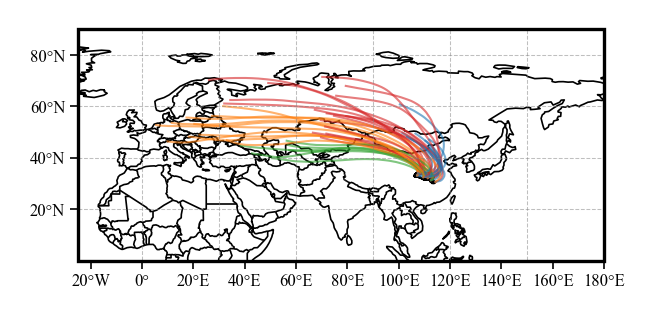

In [ ]:
# ---------- 导入 ----------
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import numpy as np

# ---------- 字体 ----------
mpl.rcParams['font.sans-serif'] = ['Times New Roman']   # 避免中文警告可换 SimHei
mpl.rcParams['axes.unicode_minus'] = False

# ---------- 画布 ----------
w_in = 58 / 25.4               # 58 mm → inch
h_in = w_in * 0.6              # 按 10:6 比例
fig  = plt.figure(figsize=(w_in, h_in), dpi=300)
ax   = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# ---------- 底图 ----------
ax.set_extent([-25, 180, 0, 90], crs=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)

# ---------- 研究区 shp ----------
shp_path = r"E:\VIC_INPUT\汉江_流域边界.shp"
roi = cfeature.ShapelyFeature(
    shpreader.Reader(shp_path).geometries(),
    ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=0.5)
ax.add_feature(roi)

# ---------- 轨迹 ----------
cmap = plt.get_cmap('tab10')
colors = {cid: cmap(i) for i, cid in enumerate(np.unique(labels))}
for lab, tr in zip(labels, tracks_3d):
    ax.plot(tr[:, 1], tr[:, 0], color=colors[lab],
            lw=0.5, alpha=0.6, transform=ccrs.PlateCarree())

# ---------- 网格线 ----------
ax.gridlines(crs=ccrs.PlateCarree(),
             linewidth=0.25, linestyle='--', color='gray', alpha=0.5)

# ---------- ① 手动刻度 & 标签 ----------
xticks = np.arange(-20, 181, 40)
yticks = [20, 40, 60, 80]            # 只保留四个纬度
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())

# 格式化标签
ax.set_xticklabels([f"{abs(x):.0f}°{'W' if x<0 else 'E' if x>0 else ''}"
                    for x in xticks], fontsize=4)
ax.set_yticklabels([f"{y}°N" for y in yticks], fontsize=4)

# ② 调整刻度线外突
ax.tick_params(axis='both', which='major',
               direction='out', length=2, width=0.4, pad=1)

plt.tight_layout()
fig.savefig("single_month_clusters.png", dpi=300)
plt.show()




In [35]:
from pathlib import Path
import numpy as np
import pandas as pd

# -------------- 前置：确保 tracks_3d 与 labels 已存在 ----------------
# >>> 如果仍停留在之前的代码单元，直接继续运行即可，无需再次加载

# -------------- 1. 创建输出目录 ---------------------------------------
out_dir = Path(r"D:\Github\HYSPLITwithERA5\traj_clusters")
out_dir.mkdir(exist_ok=True)

# -------------- 2. 计算并保存平均轨迹 ---------------------------------
for cid in np.unique(labels):
    mean_traj = tracks_3d[labels == cid].mean(axis=0)     # (T, 2)
    df = pd.DataFrame(mean_traj, columns=["lat", "lon"])
    df.to_csv(out_dir / f"cluster_{cid}_mean.csv", index=False)

print("已生成文件：")
print("\n".join(str(p) for p in sorted(out_dir.glob("*.csv"))))


已生成文件：
D:\Github\HYSPLITwithERA5\traj_clusters\centroids_meta_clustered.csv
D:\Github\HYSPLITwithERA5\traj_clusters\cluster_1_mean.csv
D:\Github\HYSPLITwithERA5\traj_clusters\cluster_2_mean.csv
D:\Github\HYSPLITwithERA5\traj_clusters\cluster_3_mean.csv
D:\Github\HYSPLITwithERA5\traj_clusters\cluster_4_mean.csv
D:\Github\HYSPLITwithERA5\traj_clusters\jan_meta_cluster_labels.csv


d:\ANACODA\envs\hysplit\Lib\site-packages\cartopy\mpl\geoaxes.py:527: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from font(s) DejaVu Sans.
  super()._update_title_position(renderer)
d:\ANACODA\envs\hysplit\Lib\site-packages\cartopy\mpl\geoaxes.py:527: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  super()._update_title_position(renderer)
d:\ANACODA\envs\hysplit\Lib\site-packages\cartopy\mpl\geoaxes.py:527: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) DejaVu Sans.
  super()._update_title_position(renderer)
d:\ANACODA\envs\hysplit\Lib\site-packages\cartopy\mpl\geoaxes.py:527: UserWarning: Glyph 36712 (\N{CJK UNIFIED IDEOGRAPH-8F68}) missing from font(s) DejaVu Sans.
  super()._update_title_position(renderer)
d:\ANACODA\envs\hysplit\Lib\site-packages\cartopy\mpl\geoaxes.py:527: UserWarning: Glyph 36857 (\N{CJK UNIFIED IDEOGRAPH-8FF9}) missing from font(s) DejaVu Sans.
  super()._update_

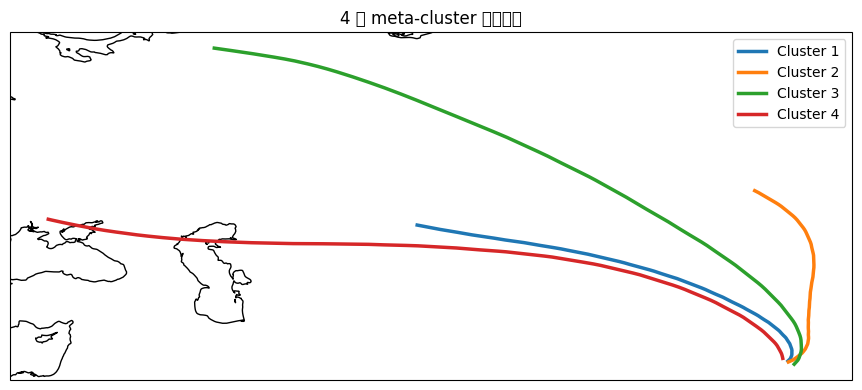

In [3]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

mean_dir = Path(r"D:\Github\HYSPLITwithERA5\traj_clusters")
files = sorted(mean_dir.glob("cluster_*_mean.csv"))

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,4))
ax  = fig.add_subplot(1,1,1, projection=proj)
ax.coastlines() 

for f in files:
    df = pd.read_csv(f)
    cid = f.stem.split('_')[1]
    ax.plot(df['lon'], df['lat'],
            label=f"Cluster {cid}",
            lw=2.5,
            transform=proj)

ax.legend()
ax.set_title("4 个 meta-cluster 平均轨迹")
plt.tight_layout()
plt.show()


In [9]:
help(ps.spawn_clusters)

Help on function spawn_clusters in module pysplit.hy_processor:

spawn_clusters(trajgroup, assignment_file, cluspath_dir)
    Make ``ClusterGroup`` from ``trajgroup``.

    Acquires the distribution of ``Trajectories`` in ``trajgroup``
    from ``assignment_file`` and creates new ``Cluster`` and ``ClusterGroup``
    instances based on that information

    Parameters
    ----------
    assignment_file : string
        The name of the 'CLUSLIST_#' file that indicates the assignment of each
        ``Trajectory``  to a ``Cluster``

    Returns
    -------
    clustergroup : `ClusterGroup` instance
        A group of `Clusters` derived from original ``TrajectoryGroup``
        (``trajgroup``).  A ``ClusterGroup`` consists of a list of ``Cluster``
        objects, which are specialized ``TrajectoryGroup`` objects.



In [3]:
help(ps.make_trajectorygroup)

Help on function make_trajectorygroup in module pysplit.hy_processor:

make_trajectorygroup(signature)
    Initialize ``Trajectory`` instances from HYSPLIT trajectory data files.

    Parameters
    ----------
    signature : string or iterable of strings
        Signature shared by a group of HYSPLIT simulation files from one or
        multiple model runs (if multiple, must contain same output variables).
        This is a Bash-style signature, not a real expression.  The `*` char is
        a wildcard. Can include an absolute or relative path, or no path to
        target the current directory. If ``signature`` is not a string, it is
        assumed to be an iterable containing path(s) to specifc HYSPLIT files.

    Returns
    -------
    trajectories : ``TrajectoryGroup``
        ``TrajectoryGroup`` object containing ``Trajectory`` instances created
        from all simulation files matching ``signature``.



AttributeError: module 'pysplit' has no attribute 'print_clusteringprocedure'

In [5]:
path = r'F:\ERA5_pressure_level\traj_clusters\1979_2019_02_P10\DELPCT'
data = np.loadtxt(path, usecols=(0,1,2))
ks = data[:, 1].astype(int) 
delpct = data[:, 2] 
diffs = np.diff(delpct)

In [6]:
diffs

array([-1.74, -0.96, -1.34, ..., -0.76,  6.25, 41.04])

In [2]:
import numpy as np
from kneed import KneeLocator
def find_elbow_by_line(ks, pct):
    x1, y1 = ks[0], pct[0]
    x2, y2 = ks[-1], pct[-1]
    ks = np.array(ks)
    pct = np.array(pct)
    
    # 计算所有点到线段的垂直距离
    numerator = np.abs((y2 - y1)*ks - (x2 - x1)*pct + x2*y1 - y2*x1)
    denom = np.hypot(y2 - y1, x2 - x1)
    distances = numerator / denom
    
    idx = np.argmax(distances)
    return int(ks[idx]), distances, idx



In [17]:
path = r'F:\ERA5_pressure_level\traj_clusters\1979_2019_07_P10\DELPCT'
data = np.loadtxt(path, usecols=(0,1,2))
ks = data[:, 1].astype(int) 
delpct = data[:, 2]
mask = (ks >= 1) & (ks <= 15)
ks_small = ks[mask]
delpct_small = delpct[mask]
order = np.argsort(ks_small)
ks_small = ks_small[order]
delpct_small = delpct_small[order]

# --- 3. 使用 kneed 自动寻找 “肘部” ---
kl = KneeLocator(
    ks_small, delpct_small,
    curve="convex",
    direction="decreasing",
    S=1.0,
    online=True
)
best_k = kl.knee  # 或 kl.elbow
print(f"✅ 自动识别之最佳聚类数 K = {best_k}")


✅ 自动识别之最佳聚类数 K = 5


In [13]:
delpct_small

array([57.31, 46.26, 15.92, 16.55, 15.6 , 10.55, 11.33,  6.79,  4.84,
        4.76,  4.81,  4.11,  3.89,  3.08,  3.01])

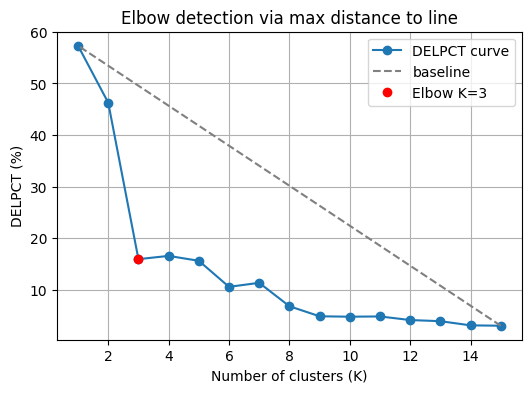

In [10]:
# 可视化结果
plt.figure(figsize=(6,4))
plt.plot(ks_small, delpct_small, 'o-', label='DELPCT curve')
plt.plot([ks_small[0], ks_small[-1]], [delpct_small[0], delpct_small[-1]], '--', color='gray', label='baseline')
plt.plot(ks_small[idx], delpct_small[idx], 'ro', label=f'Elbow K={best_k}')
plt.xlabel('Number of clusters (K)')
plt.ylabel('DELPCT (%)')
plt.title('Elbow detection via max distance to line')
plt.legend()
plt.grid(True)
plt.show()